In [1]:
# Imports
import argparse
import matplotlib.pyplot as plt
import numpy as np

from sharpness.dataloader import generate_synthetic_data, load_data, synthetic_f
from sharpness.transforms import apply_transform, transform_d
from sharpness.metric_list import metric_f, single_metrics
from sharpness import compute_metric_globally, compute_metric_locally, compute_all_metrics_globally, compute_all_metrics_locally

from sharpness.benchmark import visualize, heatmap_visualize

# low level functions:
from sharpness.dataloader import *
from sharpness.transforms import *

Loading data from ../data/kh_ABI_C13.nc (sample 50)
Loading data from ../data/kh_MRMS_REFC.nc (sample 50)
Loading data from ../data/kh_GREMLIN_REFC.nc (sample 50)


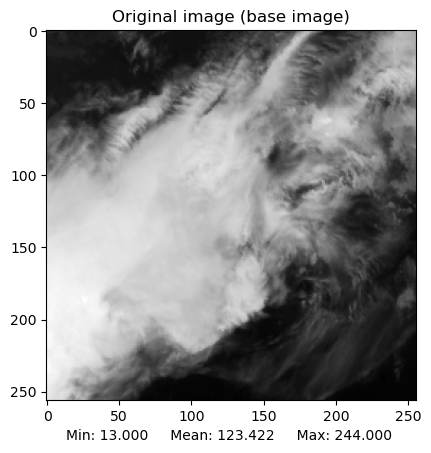

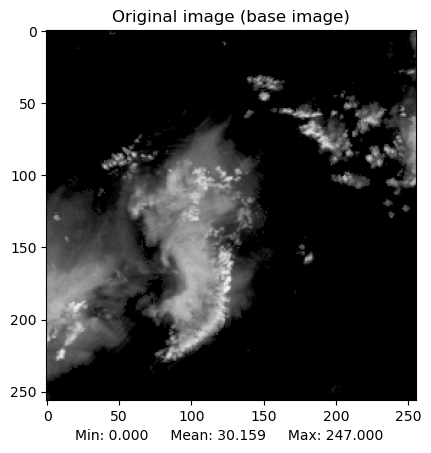

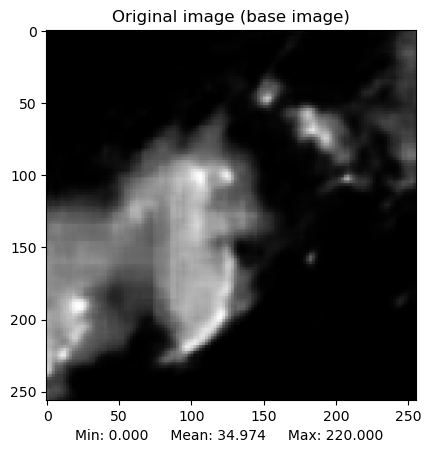

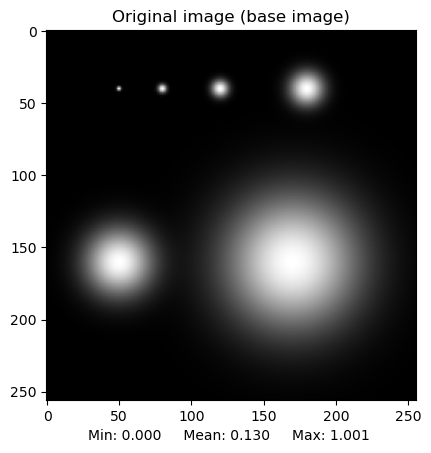

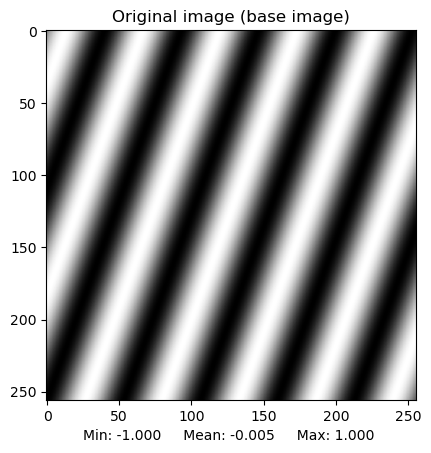

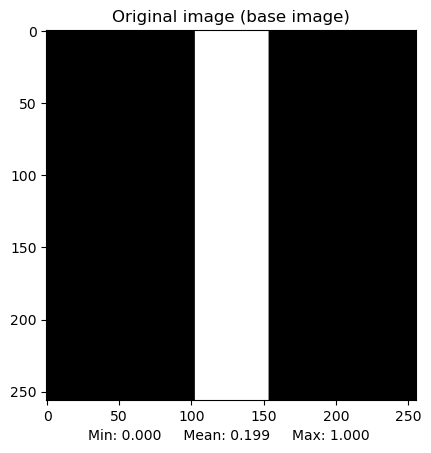

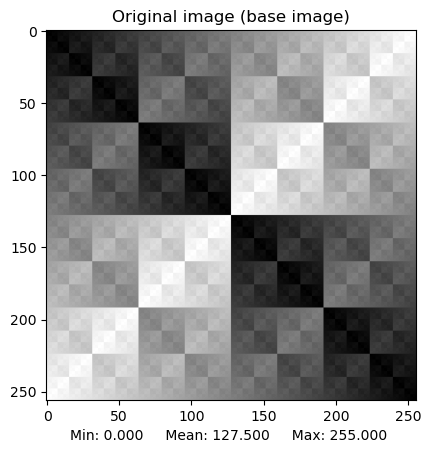

In [2]:
########################################################
# Step 1:  Set up base images to use for testing
########################################################

############ A) CREATE SYNTHETIC IMAGES ###########

############ Gaussian blob
n_pixels=256
# Create four blobs in image
center_x=40;     center_y=50;    sigma=1;    data1 = gaussian_blob(n_pixels, center_x, center_y, sigma)
center_x=40;     center_y=80;    sigma=2;    data2 = gaussian_blob(n_pixels, center_x, center_y, sigma)
center_x=40;     center_y=120;   sigma=4;    data3 = gaussian_blob(n_pixels, center_x, center_y, sigma)
center_x=40;     center_y=180;   sigma=8;    data4 = gaussian_blob(n_pixels, center_x, center_y, sigma)
center_x=160;    center_y=50;    sigma=16;   data5 = gaussian_blob(n_pixels, center_x, center_y, sigma)
center_x=160;    center_y=170;   sigma=32;   data6 = gaussian_blob(n_pixels, center_x, center_y, sigma)

# final image
original_img_Gaussian = data1 + data2 + data3 + data4 + data5 + data6

############ Sinusoidal grating
n_pixels=256
wave_length_in_pixels=50
alpha_in_degrees=20
# final image
original_img_sinusoidal = sinusoidal_grating(n_pixels, wave_length_in_pixels, alpha_in_degrees)

############ Single ridge
n_pixels = 256
fraction = fraction=0.6
img_1 = black_white(n_pixels, fraction)
fraction = fraction=0.4
img_2 = black_white(n_pixels, fraction)
original_img_ridge = img_2 - img_1

############ XOR fractal
n_pixels=256
original_img_fractal = xor_fractal( n_pixels )

############ B) LOAD OBSERVED IMAGES ############
file_name_satellite = '../data/kh_ABI_C13.nc'      # Sample satellite image 
file_name_radar = '../data/kh_MRMS_REFC.nc'        # Corresponding radar image
file_name_radar_CNN = '../data/kh_GREMLIN_REFC.nc' # Corresponding CNN estimate of radar (using satellite image as input)

i_sample = 50  # Choose any sample
original_img_satellite = load_data(file_name_satellite, i_sample)
original_img_RADAR     = load_data(file_name_radar, i_sample)
original_img_RADAR_CNN = load_data(file_name_radar_CNN, i_sample)

selected_images = ( original_img_satellite, original_img_RADAR, original_img_RADAR_CNN, original_img_Gaussian, original_img_sinusoidal, original_img_ridge, original_img_fractal )
fig_counter=0
for img in selected_images:
    plt.figure( fig_counter )
    plt.imshow(img, cmap='gray')
    plt.title('Original image (base image)')
    plt.xlabel(f'Min: {img.min():.3f}     Mean: {img.mean():.3f}     Max: {img.max():.3f} ')
    plt.show()

original_image_dict = {
    'satellite'  : (original_img_satellite, "Satellite"),
    'radar'      : (original_img_RADAR, "Radar"),
    'radar_CNN'  : (original_img_RADAR_CNN, "Radar_CNN"),
    'gaussian'   : (original_img_Gaussian, "Gaussian_blobs"),
    'sinusoidal' : (original_img_sinusoidal, "Sinusoidal"),
    'ridge'      : (original_img_ridge, "Ridge"),
    'fractal'    : (original_img_fractal, "Fractal")
}
    

In [3]:
# Choose single image to analyze

# Current choices are defined in original_image_dict in cell above.

image_choice = 'satellite'
#image_choice = 'gaussian'

print(f'\n       Selected image for analysis:     {image_choice}\n')



       Selected image for analysis:     satellite



In [4]:
#############################################################################
# Step 2:  Define a set of transformations to be applied to base image.
# This is also where parameters are chosen for the different transformations.
#############################################################################

(original_img, original_img_string)= original_image_dict[image_choice]

# Apply transformation 100% of the time (randomness turned off)
rate = 1

# Original image
original_string = "Original image"
original_value_limits = ( np.min(original_img), np.max(original_img) )

# Apply the Gaussian Blur to the image
my_transform_str = 'blur' # This works
blurr_sigma = 1   # Choose parameter
blurr_string = f'{"Blurred (sigma="}{blurr_sigma:.2f}{")"}'
blurred_img = GaussianBlur(rate, sigma=blurr_sigma)(original_img)   # Why does this create a modified image even for sigma=0?

# Add Gaussian Noise to image
my_transform_str = 'noise'
noise_sigma = 0.2   # Choose parameter
noise_string = f'{"Noise added (sigma="}{noise_sigma:.2f}{"* max)"}'
noise_img = GaussianNoise(rate, noise=noise_sigma)(original_img)    # Why does this create a modified image even for noise=0?

# Apply the Brightness adjustment transformation to the image
my_transform_str = 'brightness' # This works
brightness_factor = 0.5   # Choose parameter
brightness_string = f'{"Brightness modified (factor="}{brightness_factor:.2f}{")"}'
brightness_img = AdjustBrightness(rate, brightness=brightness_factor)(original_img)

# Crop image (TBC) - Lander, can you please fill in?
my_transform_str = 'crop' 
# crop parameter
# crop_img = 
# cropstring = 

# Apply the H-flip transformation to the image
my_transform_str = 'hflip' # This works
hflip_img = RandHorizontalFlip(rate)(original_img)
hflip_string = "Flipped horizontally"

# Apply the V-flip transformation to the image
my_transform_str = 'vflip' # This works
vflip_img = RandVerticalFlip(rate)(original_img)
vflip_string = "Flipped vertically"

# Store everything in a dictionary
transformed_image_dict = { 
    'original'   : (original_img, original_string), 
    'blur'       : (blurred_img, blurr_string),
    'noise'      : (noise_img, noise_string),
    'brightness' : (brightness_img, brightness_string),
    #'crop'       : (crop_img, crop_string),
    'hflip'      : (hflip_img, hflip_string), 
    'vflip'      : (vflip_img, vflip_string)
}



##############################
     Univariate metrics

     min_value and max_value of each heatmap are printed underneath each panel.
     Note: color maps for heatmaps vary greatly.  Go from WHITE = min(0,min_value) to DARK GREEN = (max_value).
##############################


Heatmap will be computed with blocks of size 32, and has image padding of length 16
Heatmap will be computed with blocks of size 32, and has image padding of length 16
Heatmap will be computed with blocks of size 32, and has image padding of length 16
Heatmap will be computed with blocks of size 32, and has image padding of length 16
Heatmap will be computed with blocks of size 32, and has image padding of length 16
Heatmap will be computed with blocks of size 32, and has image padding of length 16
Heatmap will be computed with blocks of size 32, and has image padding of length 16
Heatmap will be computed with blocks of size 32, and has image padding of length 16
Heatmap will be computed with blocks of size 3

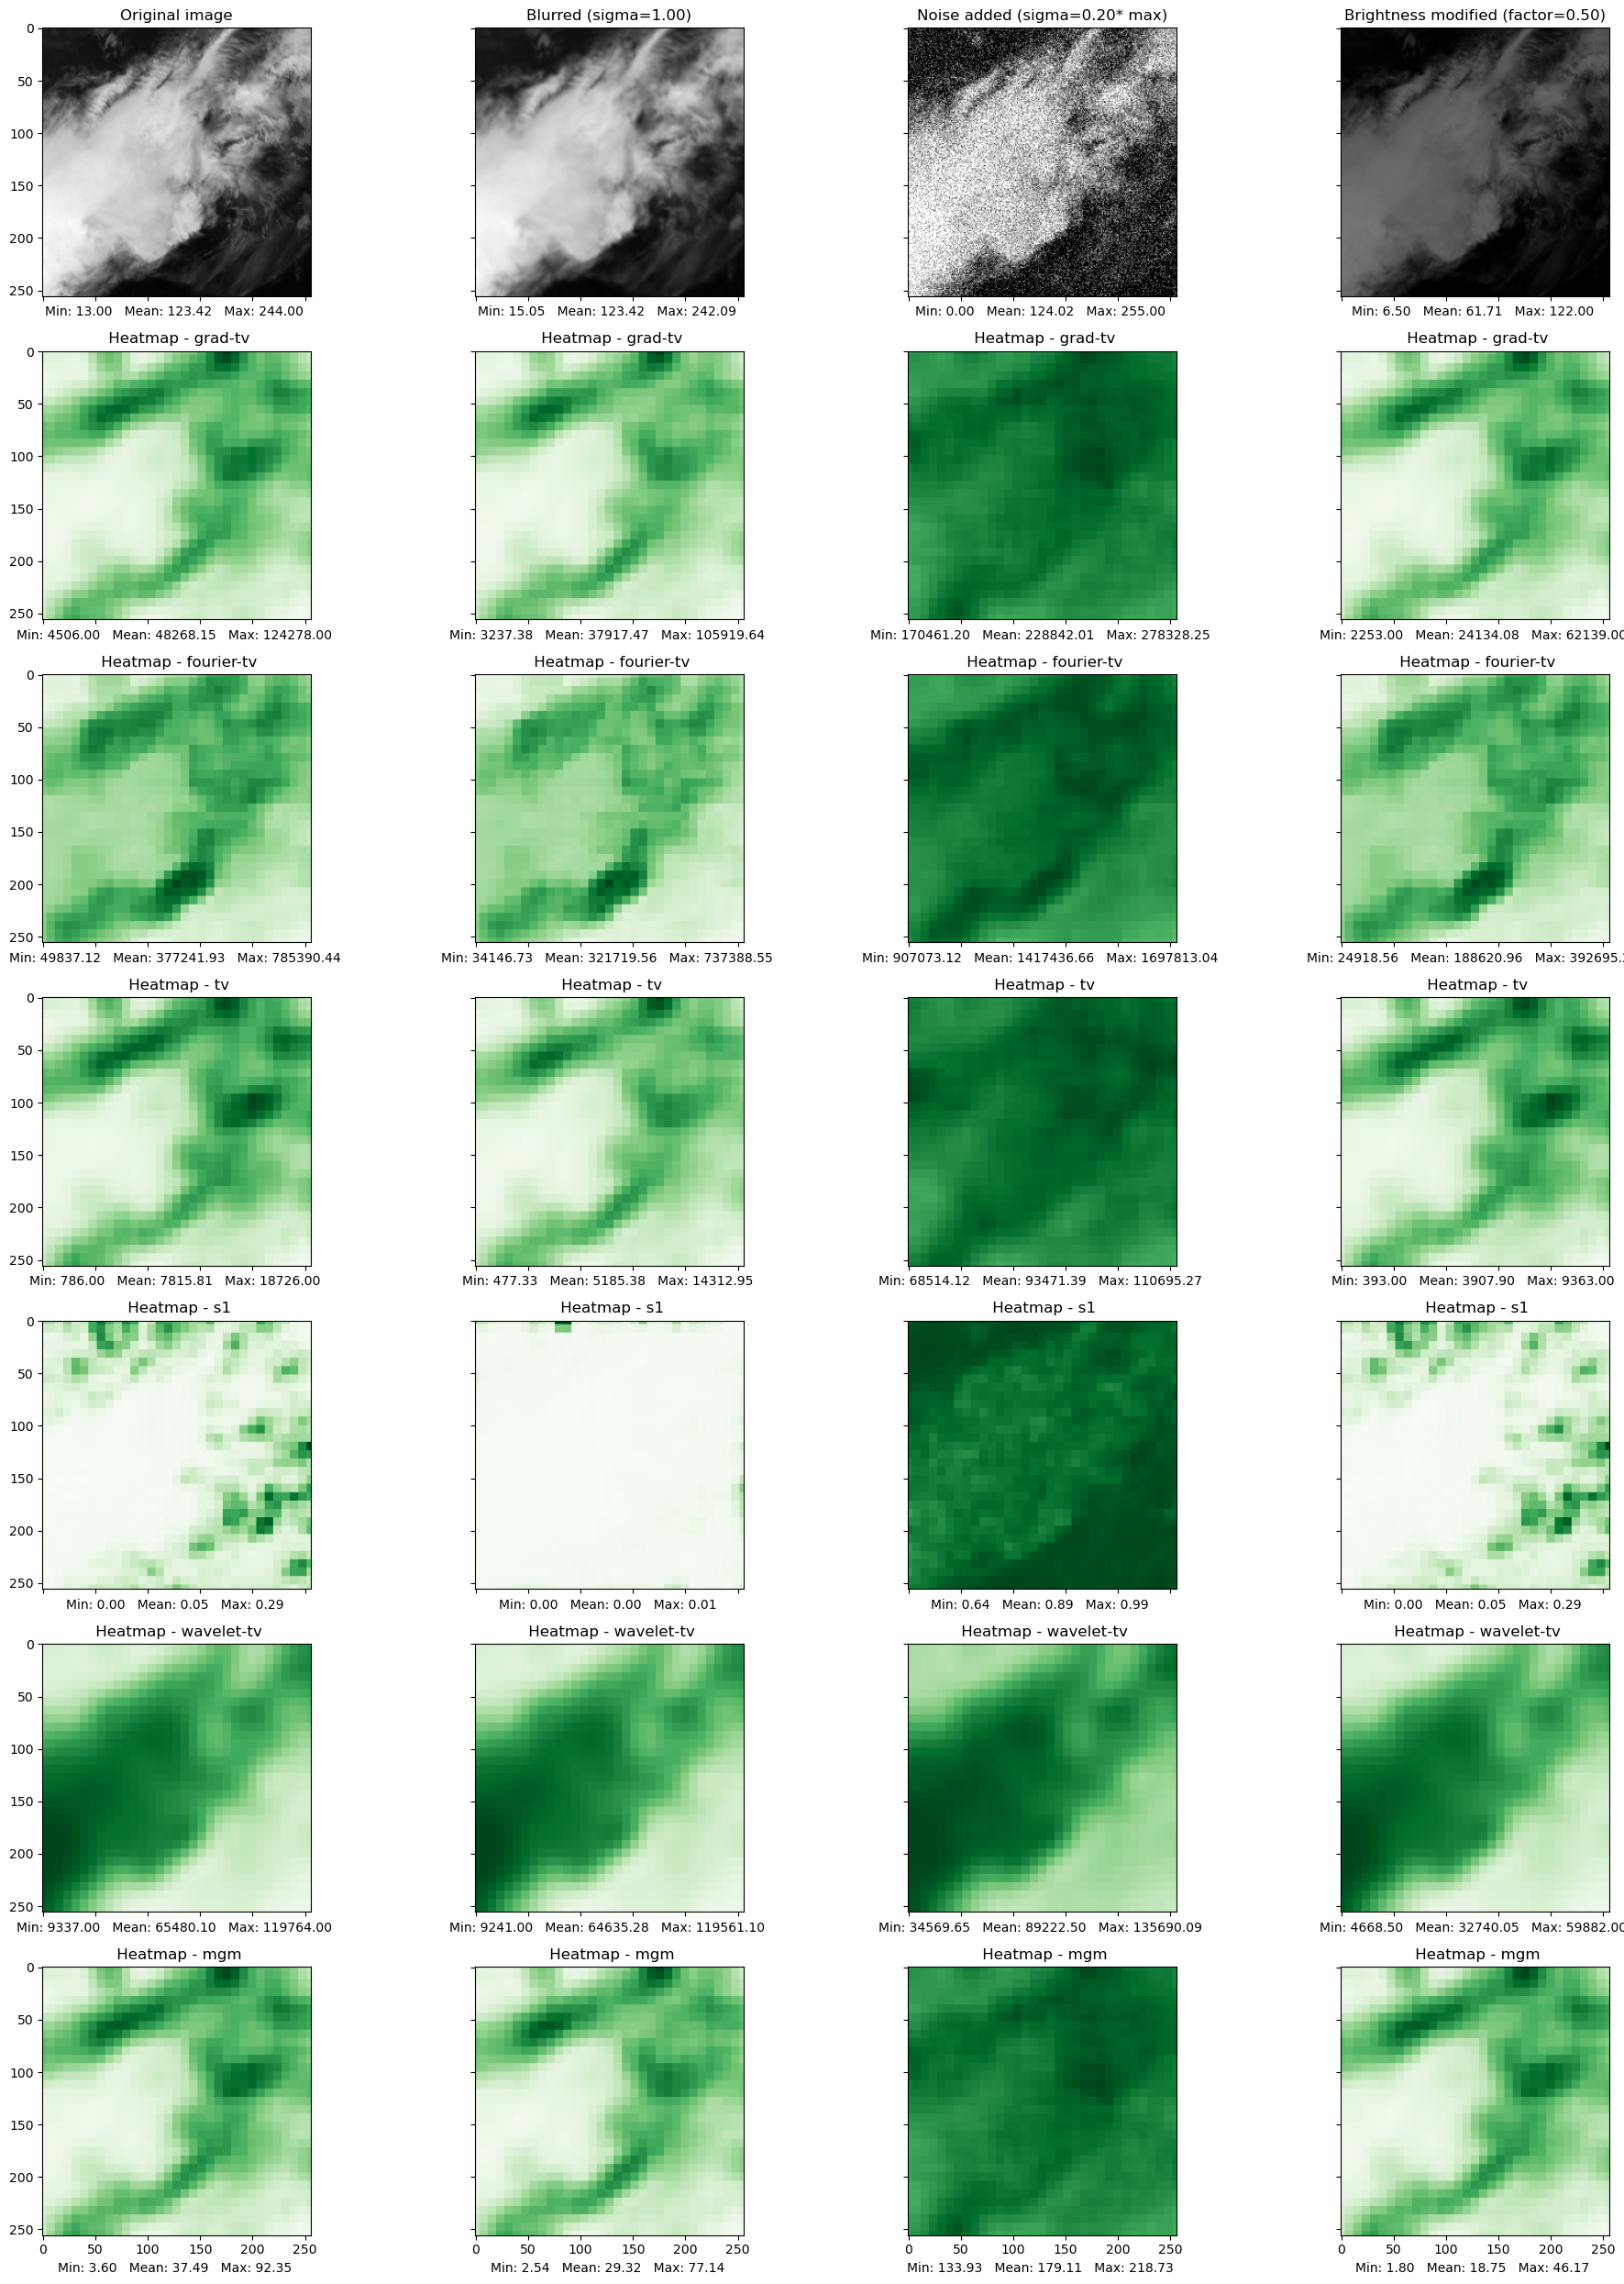

In [5]:

# Define transformations to apply in desired order
selected_transforms = [ 'original', 'hflip', 'vflip', 'brightness', 'blur', 'noise' ]

# Results for hflip and vflip always seemed the same as for original, so dropping those for now (not interesting).
selected_transforms = [ 'original', 'blur', 'noise', 'brightness' ]

print('\n##############################\n     Univariate metrics\n')
print('     min_value and max_value of each heatmap are printed underneath each panel.')
print('     Note: color maps for heatmaps vary greatly.  Go from WHITE = min(0,min_value) to DARK GREEN = (max_value).')
print('##############################\n\n')

#uni_variate_metrics = ["mgm", "s1", "tv", "grad-tv", "fourier-tv", "wavelet-tv"]
#bi_variate_metrics = ['mse', 'mae', 'rmse', 'psnr', 'ncc', 'grad-ds', 'grad-rmse', 'laplace-rmse', 'hist-int', 'hog-pearson', 'fourier-similarity', 'wavelet-similarity']

selected_metrics = { "mgm", "tv", "grad-tv", "fourier-tv", "wavelet-tv", "s1" }
# Lander - Question:  Why does this not sort the rows in the order above?

# Create a figure with subplots: columns represent transformations, rows represent metrics
fig, axs = plt.subplots(
    nrows= 1+ len(selected_metrics), ncols=len(selected_transforms), figsize=(20, 25), sharex="col", sharey="row"
)

# Go through all transforms of original image (each transform is one column)

for transform_counter, transform_key in enumerate(selected_transforms):

    # Each transform defines one column
    (img, my_string) = transformed_image_dict[transform_key]

    # First row:  plot original image and transformed images
    axs[0][transform_counter].imshow(img, clim = original_value_limits, cmap='gray' )
    axs[0][transform_counter].set_title(my_string)
    axs[0][transform_counter].set_xlabel(f'Min: {img.min():.2f}   Mean: {img.mean():.2f}   Max: {img.max():.2f} ')
    # Lander: I would like to add color bars - where does that make sense?  Also - which heatmaps makes the most sense?  

    # All other rows:  show heatmaps for each metric (each metric gets one row)
    # Go through all metrics (each metric is in one row)
    for metric_counter, my_metric in enumerate(selected_metrics, start=1):

        # Calculate heatmap for each image and each metric
        # Note that these metrics are univariate, so we only feed in one image and only care about first heatmap returned.
        img_heatmap, dummy_heatmap = compute_metric_locally(img, img, metric = my_metric)

        # The limits, thus color bars, differ for each one right now. But min/max/mean values of heatmap are printed underneath. 
        cmin = np.min( (0.0, img_heatmap.min()) )
        cmax = img_heatmap.max()
        axs[metric_counter][transform_counter].imshow(img_heatmap, clim=(cmin, cmax), cmap='Greens')
        axs[metric_counter][transform_counter].set_title(f' Heatmap - {my_metric}')
        axs[metric_counter][transform_counter].set_xlabel(f'Min: {img_heatmap.min():.2f}   Mean: {img_heatmap.mean():.2f}   Max: {img_heatmap.max():.2f} ')

# Show the figure
plt.tight_layout()
output_filename = f'Exp_{original_img_string}_Univariate.png';
print(f'Saving results to {output_filename}')
plt.savefig(output_filename)


##############################
     Bivariate metrics

     min_value and max_value of each heatmap are printed underneath each panel.
     Note: color map for heatmaps vary greatly.  Go from WHITE = min(0,min_value) to DARK GREEN = (max_value).
##############################


Heatmap will be computed with blocks of size 32, and has image padding of length 16
Heatmap will be computed with blocks of size 32, and has image padding of length 16
Heatmap will be computed with blocks of size 32, and has image padding of length 16
Heatmap will be computed with blocks of size 32, and has image padding of length 16
Heatmap will be computed with blocks of size 32, and has image padding of length 16
Heatmap will be computed with blocks of size 32, and has image padding of length 16
Heatmap will be computed with blocks of size 32, and has image padding of length 16
Heatmap will be computed with blocks of size 32, and has image padding of length 16
Heatmap will be computed with blocks of size 32,

/Users/imme/anaconda3/envs/ai2es-sharpness/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Heatmap will be computed with blocks of size 32, and has image padding of length 16
Heatmap will be computed with blocks of size 32, and has image padding of length 16
Heatmap will be computed with blocks of size 32, and has image padding of length 16
Heatmap will be computed with blocks of size 32, and has image padding of length 16
Heatmap will be computed with blocks of size 32, and has image padding of length 16
Heatmap will be computed with blocks of size 32, and has image padding of length 16
Heatmap will be computed with blocks of size 32, and has image padding of length 16
Heatmap will be computed with blocks of size 32, and has image padding of length 16
Heatmap will be computed with blocks of size 32, and has image padding of length 16
Heatmap will be computed with blocks of size 32, and has image padding of length 16
Heatmap will be computed with blocks of size 32, and has image padding of length 16
Heatmap will be computed with blocks of size 32, and has image padding of le

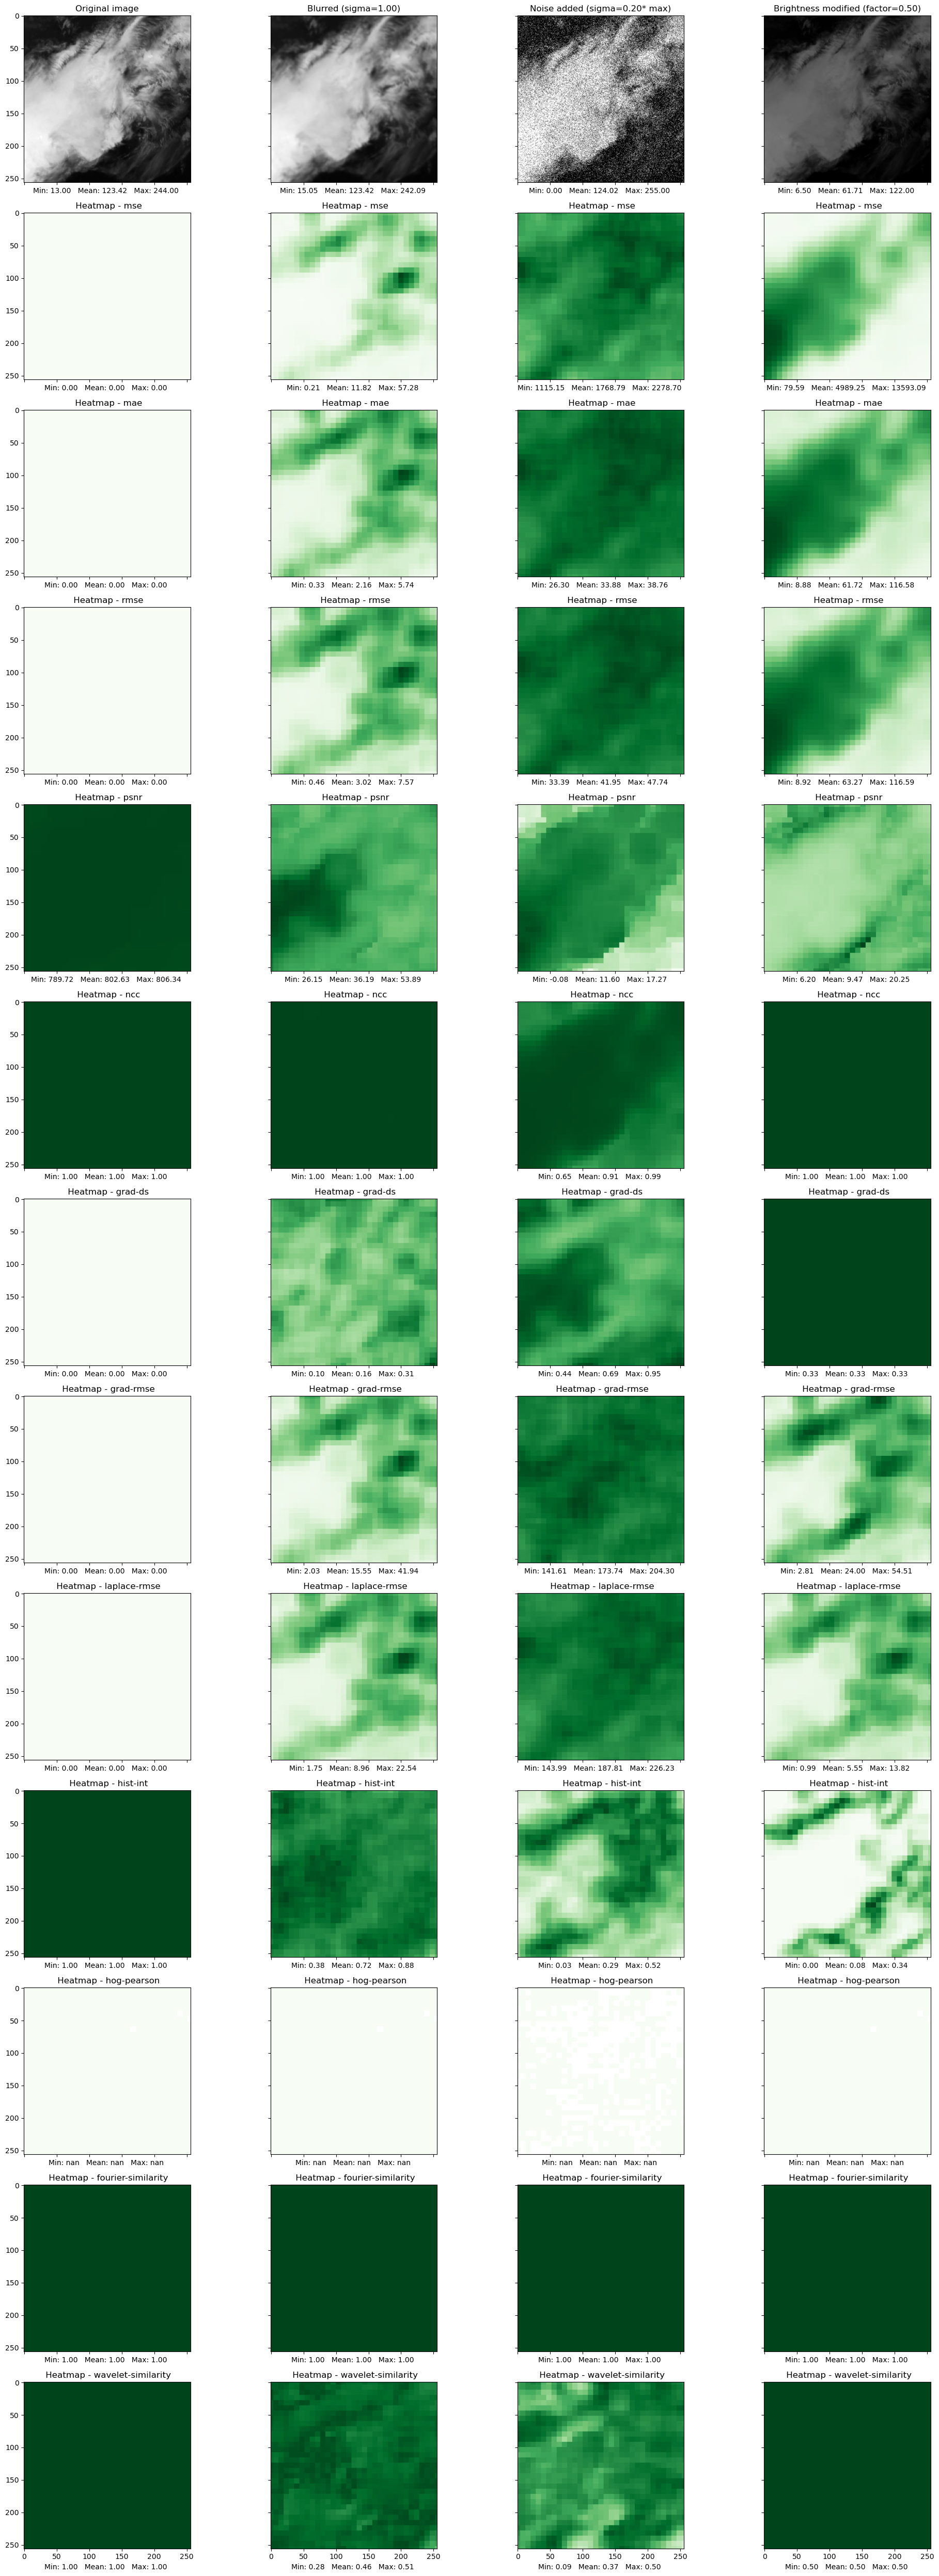

In [6]:
    # Select a single metric, then plot sharpness heat maps for all transforms.
    
    # Define transformations to apply in desired order
    selected_transforms = [ 'original', 'hflip', 'vflip', 'brightness', 'blur', 'noise' ]
    selected_transforms = [ 'original', 'blur', 'noise', 'brightness' ]

    print('\n##############################\n     Bivariate metrics\n')
    print('     min_value and max_value of each heatmap are printed underneath each panel.')
    print('     Note: color map for heatmaps vary greatly.  Go from WHITE = min(0,min_value) to DARK GREEN = (max_value).')
    print('##############################\n\n')

    #uni_variate_metrics = ["mgm", "s1", "tv", "grad-tv", "fourier-tv", "wavelet-tv"]
    bi_variate_metrics = ['mse', 'mae', 'rmse', 'psnr', 'ncc', 'grad-ds', 'grad-rmse', 'laplace-rmse', 'hist-int', 'hog-pearson', 'fourier-similarity', 'wavelet-similarity']
    # Lander - Can we easily add SSIM?
    
    bi_metrics_set_1 = ['mse', 'mae', 'rmse', 'psnr', 'ncc'] # Difference in pixel space 
    bi_metrics_set_2 = ['hist-int', 'hog-pearson'] # Difference in histogram space?
    bi_metrics_set_3 = ['grad-ds', 'grad-rmse', 'laplace-rmse']   # Difference in gradient space
    bi_metrics_set_4 = ['fourier-similarity', 'wavelet-similarity'] # Difference in spectral space

    selected_metrics = bi_variate_metrics
    
    # Create a figure with subplots: columns represent transformations, rows represent metrics
    fig, axs = plt.subplots(
        #nrows= 1+ len(selected_metrics), ncols=len(selected_transforms), figsize=(2 * len(selected_metrics), 16 * len(selected_transforms)), sharex="col", sharey="row"
        nrows= 1+ len(selected_metrics), ncols=len(selected_transforms), figsize=(20, 50), sharex="col", sharey="row"
    )
    
    (original_img, original_string) = transformed_image_dict['original']
        
    for transform_counter, transform_key in enumerate(selected_transforms):
    
        # Each transform defines one column
        (img, my_string) = transformed_image_dict[transform_key]
    
        # First row:  plot original image and transformed images
        axs[0][transform_counter].imshow(img, clim = original_value_limits, cmap='gray' )
        axs[0][transform_counter].set_title(my_string)
        axs[0][transform_counter].set_xlabel(f'Min: {img.min():.2f}   Mean: {img.mean():.2f}   Max: {img.max():.2f} ')
        # Lander: I would like to add color bars - where does that make sense?  Also - which heatmaps makes the most sense?  
    
        # All other rows:  show heatmaps for different metrics  (each metric gets one row)
        for metric_counter, my_metric in enumerate(selected_metrics, start=1):
            
            img_heatmap = compute_metric_locally(original_img, img, metric = my_metric)
            cmin = np.min( (img_heatmap.min(), 0) )
            cmax = img_heatmap.max()
            axs[metric_counter][transform_counter].imshow(img_heatmap, clim=(cmin, cmax), cmap='Greens')
            axs[metric_counter][transform_counter].set_title(f' Heatmap - {my_metric}')
            axs[metric_counter][transform_counter].set_xlabel(f'Min: {img_heatmap.min():.2f}   Mean: {img_heatmap.mean():.2f}   Max: {img_heatmap.max():.2f} ')
            
    # Show the figure
    plt.tight_layout()
    output_filename = f'Exp_{original_img_string}_Bivariate.png';
    print(f'Saving results to {output_filename}')
    plt.savefig(output_filename)


In [7]:
### COMPARE Observed radar to CNN-generated radar image

# TBC
